In [1]:
from __future__ import division
import os
import cv2
import numpy as np

import torch
from mmcv import Config
from mmcv.runner import load_checkpoint

from mmfashion.datasets import build_dataloader, build_dataset
from mmfashion.models import build_retriever
from mmfashion.utils import get_img_tensor

from scipy.spatial.distance import cosine as cosine

import matplotlib.pyplot as plt

In [2]:
input_img_path = './../test.jpg'
config = './configs/retriever_in_shop/global_retriever_resnet.py'
checkpoint = './checkpoint/retrieval_resnet_global.pth'
data_path = './data/In-shop/Img/'

In [3]:
class ClothesRetriever(object):
    def __init__(self, gallery_im_fn, data_dir, img_path, topks=[5], extract_feature=False):
        self.topks = topks
        self.data_dir = data_dir
        self.img_path = img_path
        self.gallery_idx2im = {}
        gallery_imgs = open(gallery_im_fn).readlines()
        for i, img in enumerate(gallery_imgs):
            self.gallery_idx2im[i] = img.strip('\n')

    def show_topk_retrieved_images(self, retrieved_idxes):
        images = []
        for idx in retrieved_idxes:
            retrieved_img = self.gallery_idx2im[idx]
            images.append(retrieved_img)
        return images

    def show_retrieved_images(self, query_feat, gallery_embeds):
        query_dist = []
        for i, feat in enumerate(gallery_embeds):
            cosine_dist = cosine(
                feat.reshape(1, -1), query_feat.reshape(1, -1))
            query_dist.append(cosine_dist)

        query_dist = np.array(query_dist)
        order = np.argsort(query_dist)
        print(order)
        return order
#         for topk in self.topks:
#             print('Retrieved Top%d Results' % topk)
#             self.show_topk_retrieved_images(order[:topk])

In [4]:
def _process_embeds(dataset, model, cfg, use_cuda=True):
    data_loader = build_dataloader(
        dataset,
        cfg.data.imgs_per_gpu,
        cfg.data.workers_per_gpu,
        len(cfg.gpus.test),
        dist=False,
        shuffle=False)

    embeds = []
    with torch.no_grad():
        for data in data_loader:
            if use_cuda:
                img = data['img'].cuda()
            embed = model(img, landmark=data['landmark'], return_loss=False)
            embeds.append(embed)

    embeds = torch.cat(embeds)
    embeds = embeds.data.cpu().numpy()
    return embeds

In [5]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

cfg = Config.fromfile(config)

model = build_retriever(cfg.model)
load_checkpoint(model, checkpoint)
print('load checkpoint from {}'.format(checkpoint))

model.cuda()
model.eval()
print('Load Success !')

pretrained model checkpoint/resnet50.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

load checkpoint from ./checkpoint/retrieval_resnet_global.pth
Load Success !


In [6]:
img_tensor = get_img_tensor(input_img_path, use_cuda=True)

feature_vector = model(img_tensor, landmark=None, return_loss=False)
feature_vector = feature_vector.data.cpu().numpy()

In [7]:
gallery_set = build_dataset(cfg.data.gallery)

In [8]:
retriever = ClothesRetriever(cfg.data.gallery.img_file, cfg.data_root, cfg.data.gallery.img_path)

In [9]:
gallery_embeds = _process_embeds(gallery_set, model, cfg)
ls = retriever.show_retrieved_images(feature_vector, gallery_embeds)

[6536 1627 1626 ... 2715 3689 8806]


In [10]:
images = retriever.show_topk_retrieved_images(ls[:5])

Your input image !


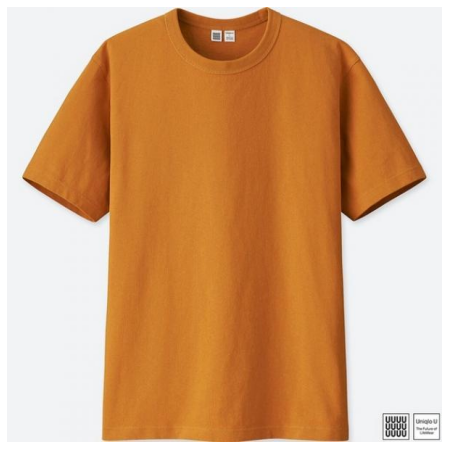

Find Retrievel : ./data/In-shop/Img/img/MEN/Tees_Tanks/id_00004117/24_1_front.jpg


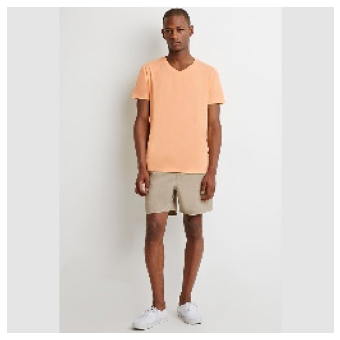

Find Retrievel : ./data/In-shop/Img/img/WOMEN/Dresses/id_00001124/04_3_back.jpg


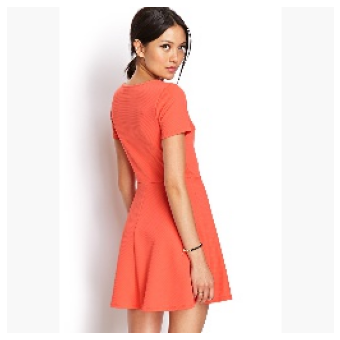

Find Retrievel : ./data/In-shop/Img/img/WOMEN/Dresses/id_00001124/04_2_side.jpg


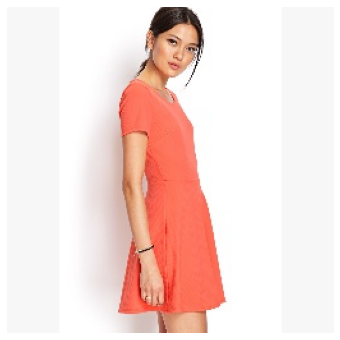

Find Retrievel : ./data/In-shop/Img/img/MEN/Tees_Tanks/id_00004530/18_2_side.jpg


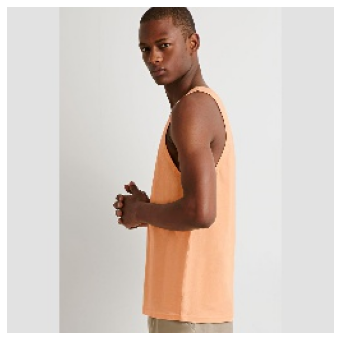

Find Retrievel : ./data/In-shop/Img/img/WOMEN/Blouses_Shirts/id_00005497/03_7_additional.jpg


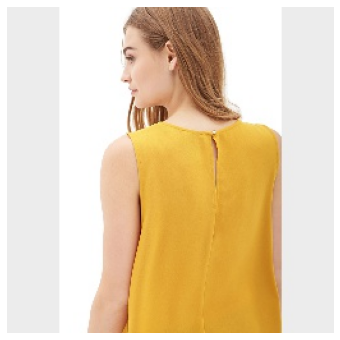

In [11]:
test_img = cv2.imread(input_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

print('Your input image !')
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(test_img)
plt.show()

for ind, ret_path in enumerate(images):
    ret_path = os.path.join(data_path, ret_path)
    print(f'Find Retrievel : {ret_path}')

    ret_img = cv2.imread(ret_path)
    ret_img = cv2.cvtColor(ret_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(ret_img)
    plt.show()